# Combustion analysis in a coal-fired power plant

In [1]:
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
DATA_FILE = "a08r.mat"
ARRAY_NAME = "a08r"
SPS = 300 # Samples per second

        ch1       ch2       ch3       ch4       ch5
0  0.049816  0.179095  0.170236  0.177783  0.679478
1  0.048832  0.177783  0.170236  0.177455  0.679150
2  0.049488  0.178111  0.170236  0.177455  0.678165


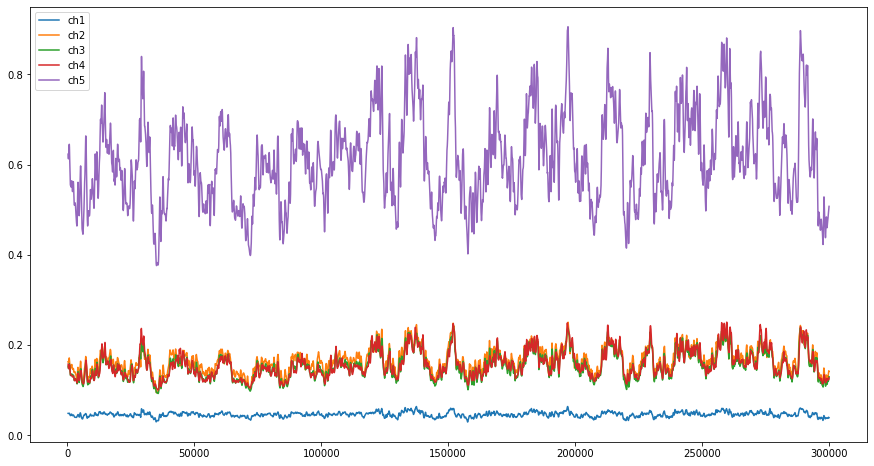

In [4]:
if __name__ == "__main__":
    data = pd.DataFrame(loadmat(DATA_FILE)[ARRAY_NAME], columns=(["ch1", "ch2", "ch3", "ch4", "ch5"]))
    print(data.head(3))    
    
    plt.figure(figsize=(15, 8))
    plt.plot(data.head(300000).rolling(SPS).mean(), label=data.columns)
    plt.legend()
    plt.show()